In [1]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, GRU, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [2]:
df = pd.read_csv('../Dataset/Twitter_Suicide_Data_new.csv')

In [3]:
df

,Id,Content,Sentiment
0,4.964062e+07,The end.,Negative
1,4.350528e+07,GOD OVER EVERYTHING.,Negative
2,4.350528e+07,I'm sorry.,Negative
3,4.350528e+07,God... please forgive me.,Negative
4,4.350528e+07,This day couldn't get any worse...,Negative
...,...,...,...
298,9.334510e+17,"endless pain in life,end it",Negative
299,9.368910e+17,lets ave a lot of fun,Positive
300,9.123420e+17,"Nothing left in this world for me,i want to die",Negative
301,9.368910e+17,I am successful in life,Positive


In [4]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

In [6]:
from collections import Counter

print(Counter(df_train['Sentiment']))
print(Counter(df_test['Sentiment']))
print(Counter(df_val['Sentiment']))

Counter({'Negative': 111, 'Positive': 82})
Counter({'Negative': 40, 'Positive': 21})
Counter({'Positive': 25, 'Negative': 24})


In [7]:
encoding = { 'Negative': 0,
    'Positive': 1,
}

y_train = np.array([encoding[key] for key in df_train['Sentiment'].values])
y_test = np.array([encoding[key] for key in df_test['Sentiment'].values])
y_val = np.array([encoding[key] for key in df_val['Sentiment'].values])

In [8]:
EMBEDDING_FILE = 'wiki-news-300d-1M.vec'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

In [9]:
import nltk
# Uncomment to download "stopwords"
#nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [10]:
import re

# Preprocess text
X_train_preprocessed = [text_preprocessing(text) for text in df_train['Content'].values]
X_val_preprocessed = [text_preprocessing(text) for text in df_val['Content'].values]
X_test_preprocessed = [text_preprocessing(text) for text in df_test['Content'].values]

In [11]:
X_train_preprocessed

['rt gotta love can properly love someone else',
 'looks dejected sad http co 3nivkahtho',
 'think would better ended',
 'believed guy sent threatening emails roger williams law school earlier today',
 'rt congratulations taking asia regional finals title thanks giving',
 'sounds pretty fine pleased hear creepy cup tea',
 'rt makes heart full joy god faithful congrats https co iyci1ssx2u',
 'rt feeling going great day got meet john stockton game',
 'feeling hopeless n want 2 die not like matters anyways 1 cares',
 'rt sometimes ifeel like family would better without',
 'ways positive thinking https co phcdr0voym https co e5iedwwlif',
 'true say start thinking positive happier',
 'rt one year retirement hope enjoying busy pensioner life https co ivepmoqv07',
 'suga suran one stage kill kill',
 'rt congratulations gorb graduating middle school hope strive greatness like cod4',
 'rt armys win lose reward youself deserve not beat love',
 'rt baha world celebrating bicentenary birth baha u 

In [12]:
MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train_preprocessed + X_val_preprocessed)

sequences_train = tokenizer.texts_to_sequences(X_train_preprocessed)
sequences_val = tokenizer.texts_to_sequences(X_val_preprocessed)
sequences_test = tokenizer.texts_to_sequences(X_test_preprocessed)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 767 unique tokens


In [13]:
MAX_SEQUENCE_LENGTH = 140
data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
data_val = pad_sequences(sequences_val, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data_train.shape)

Shape of data tensor: (193, 140)


In [14]:
EMBEDDING_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

In [15]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < len(word_index):
        embedding_matrix[idx] = word2vec.word_vec(word)

In [16]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0286      0.1001     -0.1847     ... -0.0407      0.1
  -0.0809    ]
 [ 0.0652     -0.0034     -0.0353     ...  0.15979999 -0.0594
  -0.0351    ]
 ...
 [-0.0787     -0.043      -0.15970001 ...  0.17739999  0.1245
   0.075     ]
 [-0.0591     -0.0787      0.14219999 ...  0.1741     -0.1155
  -0.0647    ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(768, 300)


In [17]:
print(data_train)
print(data_val)
print(data_test)
print(y_train)
print(y_val)
print(y_test)

[[  0   0   0 ...   4  67  88]
 [  0   0   0 ...  20   6 260]
 [  0   0   0 ...  15  16 261]
 ...
 [  0   0   0 ... 642 104 643]
 [  0   0   0 ... 242 648 649]
 [  0   0   0 ...   0  64  39]]
[[  0   0   0 ... 241  99 652]
 [  0   0   0 ...   0 653  39]
 [  0   0   0 ...  48  26  35]
 ...
 [  0   0   0 ...  31 762 763]
 [  0   0   0 ...  21 765   3]
 [  0   0   0 ... 766   2 767]]
[[  0   0   0 ...  70  76  72]
 [  0   0   0 ...  21   5  32]
 [  0   0   0 ...   0   0  34]
 ...
 [  0   0   0 ...  72   5  10]
 [  0   0   0 ... 147  98   2]
 [  0   0   0 ...   1 128  38]]
[1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1
 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1
 1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 1 0 0 0]
[1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 

In [34]:
from keras import backend as K 

# Do some code, e.g. train and save model

K.clear_session()

In [19]:
import tensorflow as tf
with tf.device('/device:GPU:1'):
    model = Sequential()
    # Embedded layer
    model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model.add(LSTM(300))
    #model.add(GRU(300))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 300)          230400    
_________________________________________________________________
conv1d (Conv1D)              (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 70, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               399600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/20
7/7 [==============================] - 0s 52ms/step - loss: 0.6876 - acc: 0.5855 - val_loss: 0.6630 - val_acc: 0.5306
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 0.6694 - acc: 0.5803 - val_loss: 0.6352 - val_acc: 0.6531
Epoch 3/20
7/7 [==============================] - 0s 11ms/step - loss: 0.6438 - acc: 0.6684 - val_loss: 0.6076 - val_acc: 0.7755
Epoch 4/20
7/7 [==============================] - 0s 11ms/step - loss: 0.5639 - acc: 0.8705 - val_loss: 1.5968 - val_acc: 0.4898
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.6007 - acc: 0.8290 - val_loss: 0.4536 - val_acc: 0.8571
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3748 - acc: 0.9171 - val_loss: 0.4407 - val_acc: 0.7551
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 0.2940 - acc: 0.8912 - val_loss: 0.6457 - val_acc: 0.8163
Epoch 8/20
7/7 [==============================] - 0s 11ms/step - loss: 0.2527 - acc: 0.9430 - val

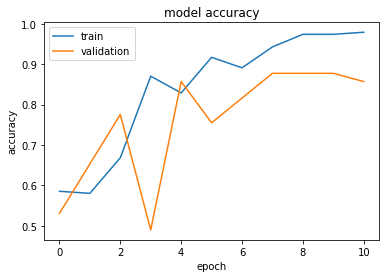

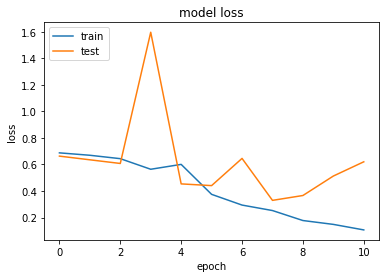

In [21]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
print(data_test)

[[  0   0   0 ...  70  76  72]
 [  0   0   0 ...  21   5  32]
 [  0   0   0 ...   0   0  34]
 ...
 [  0   0   0 ...  72   5  10]
 [  0   0   0 ... 147  98   2]
 [  0   0   0 ...   1 128  38]]


In [23]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 96.72%
F1 Score: 96.75
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.91      1.00      0.95        21

    accuracy                           0.97        61
   macro avg       0.96      0.97      0.96        61
weighted avg       0.97      0.97      0.97        61



In [24]:
model.save('model/word2vec_CNN_LSTM-Suicide.h5')

In [25]:
with tf.device('/device:GPU:1'):
    model2 = Sequential()
    # Embedded layer
    model2.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model2.add(LSTM(300))
    #model.add(GRU(300))
    model2.add(Dropout(0.2))
    model2.add(Dense(1, activation='sigmoid'))

    model2.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          230400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 951,901
Trainable params: 721,501
Non-trainable params: 230,400
_________________________________________________________________
None


In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model2.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/20
7/7 [==============================] - 0s 48ms/step - loss: 0.6656 - acc: 0.6995 - val_loss: 0.6739 - val_acc: 0.4898
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.5736 - acc: 0.7565 - val_loss: 0.7825 - val_acc: 0.7551
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.4522 - acc: 0.8342 - val_loss: 0.4994 - val_acc: 0.7755
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3855 - acc: 0.9171 - val_loss: 0.7359 - val_acc: 0.7143
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.4815 - acc: 0.7927 - val_loss: 0.4636 - val_acc: 0.7551
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.3335 - acc: 0.9430 - val_loss: 0.3509 - val_acc: 0.8367
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.6071 - acc: 0.8497 - val_loss: 0.4001 - val_acc: 0.8776
Epoch 8/20
7/7 [==============================] - 0s 13ms/step - loss: 0.2574 - acc: 0.9741 - val

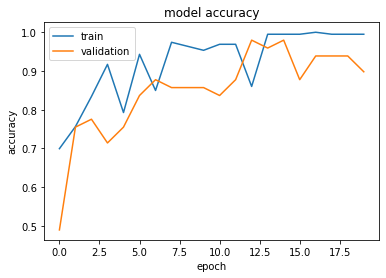

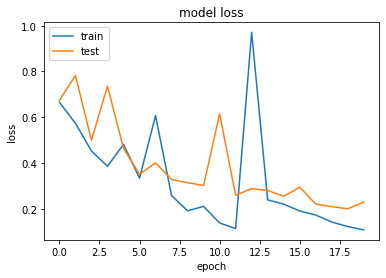

In [27]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model2.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 95.08%
F1 Score: 95.11
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.91      0.95      0.93        21

    accuracy                           0.95        61
   macro avg       0.94      0.95      0.95        61
weighted avg       0.95      0.95      0.95        61



In [29]:
model2.save('model/word2vec_LSTM-Suicide.h5')

In [45]:
with tf.device('/device:GPU:1'):
    model3 = Sequential()
    # Embedded layer
    model3.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    # Convolutional Layer
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(GlobalAveragePooling1D())
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu'))
    # LSTM Layer
    model3.add(Bidirectional(LSTM(300)))
    #model.add(GRU(300))
    model3.add(Dropout(0.2))
    model3.add(Dense(1, activation='sigmoid'))

    model3.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
    print(model3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          230400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 1,673,401
Trainable params: 1,443,001
Non-trainable params: 230,400
_________________________________________________________________
None


In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr_on_plateau_cb = ReduceLROnPlateau(verbose = 1, factor=0.1, patience=2)

with tf.device('/device:GPU:1'):
    hist = model3.fit(data_train, y_train, validation_data=(data_val, y_val), epochs=20, batch_size=32, shuffle=True, callbacks=[early_stop])

Epoch 1/20
7/7 [==============================] - 1s 81ms/step - loss: 0.7110 - acc: 0.5337 - val_loss: 0.6206 - val_acc: 0.8776
Epoch 2/20
7/7 [==============================] - 0s 23ms/step - loss: 0.6406 - acc: 0.7927 - val_loss: 0.5809 - val_acc: 0.7143
Epoch 3/20
7/7 [==============================] - 0s 22ms/step - loss: 0.5286 - acc: 0.7876 - val_loss: 0.6296 - val_acc: 0.5714
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 0.4507 - acc: 0.8290 - val_loss: 0.4177 - val_acc: 0.8571
Epoch 5/20
7/7 [==============================] - 0s 21ms/step - loss: 0.3533 - acc: 0.9534 - val_loss: 0.8305 - val_acc: 0.6327
Epoch 6/20
7/7 [==============================] - 0s 20ms/step - loss: 0.3861 - acc: 0.8964 - val_loss: 0.3805 - val_acc: 0.8571
Epoch 7/20
7/7 [==============================] - 0s 21ms/step - loss: 0.2554 - acc: 0.9275 - val_loss: 0.3098 - val_acc: 0.8776
Epoch 8/20
7/7 [==============================] - 0s 21ms/step - loss: 0.1935 - acc: 0.9378 - val

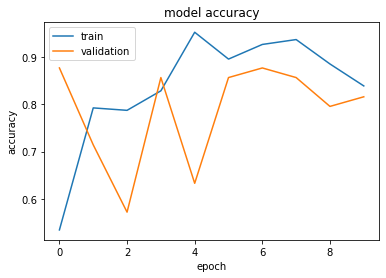

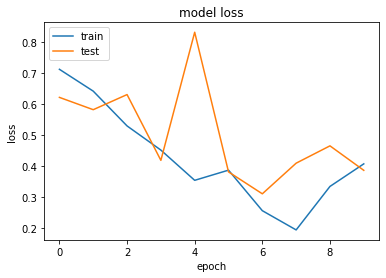

In [47]:
#plot_model(model, to_file='model.png')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score, f1_score

with tf.device('/device:GPU:1'):
    labels_pred = model3.predict(data_test)
    labels_pred = np.round(labels_pred.flatten())
    accuracy = accuracy_score(y_test, labels_pred)
    f1 = f1_score(y_test, labels_pred, average='weighted')

    print("Accuracy: %.2f%%" % (accuracy*100))
    print("F1 Score: %.2f" % (f1*100))

    print(classification_report(y_test, labels_pred))

Accuracy: 93.44%
F1 Score: 93.44
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.90      0.90      0.90        21

    accuracy                           0.93        61
   macro avg       0.93      0.93      0.93        61
weighted avg       0.93      0.93      0.93        61



In [49]:
model3.save('model/word2vec_BiLSTM-Suicide.h5')